In [1]:
import pathlib
import re

import matplotlib.pyplot as plt
import numpy as np
import tabulate
import tensorflow as tf
#plt.style.use("slides")
from tensorflow.python.keras.metrics import binary_accuracy
from link_bot_data.visualization import color_violinplot

from moonshine.moonshine_utils import repeat_tensor
plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(suppress=True, linewidth=250)

In [2]:
def myshorten(string: str):
    parts = re.split("/", string)
    indices = [3]
    shortened = '-'.join([parts[i] for i in indices])
    return shortened

infiles = {
'val': 'results/classifier_data/val_car_feasible_1614981888/val_car_feasible_ensemble/results_1615575308.npz',
'planning, rack': 'results/classifier_data/results/rack/val_car_feasible_ensemble/results_1615646688.npz',
# 'planning, long hooks1': 'results/classifier_data/results/long_hooks_1+starts-close/val_car_feasible_ensemble/results_1615575521.npz',
# 'starts-far val': 'results/classifier_data/val_car_feasible_stars_far_1614982110+only-starts-far/val_car_feasible_ensemble/results_1615489739.npz',
# 'planning, car': 'results/classifier_data/results/fss-no-starts-far-classifier-1/val_car_feasible_ensemble/',
}

data = {}
for name, infile in infiles.items():
    infile_path = pathlib.Path(infile)
    datum = np.load(infile)
    print(name, list(datum.keys()))
    data[name] = datum

names = list(data.keys())

val ['stdevs', 'is_correct', 'probabilities', 'labels', 'checkpoints', 'dataset', 'balance', 'mode', 'use_gt_rope']
planning, rack ['stdevs', 'is_correct', 'probabilities', 'labels', 'checkpoints', 'dataset', 'balance', 'mode', 'use_gt_rope']


In [3]:
table = []
for name, datum in data.items():
    uncertainty_estimate = datum['stdevs']
    # print(f'{myshorten(name):40s} {np.mean(uncertainty_estimate):.3f} {np.std(uncertainty_estimate):.3f}')
    table.append((name, np.mean(uncertainty_estimate), np.std(uncertainty_estimate)))
print(tabulate.tabulate(table, headers=['name', 'mean', 'std'], floatfmt='.3f'))


name              mean    std
--------------  ------  -----
val              0.055  0.107
planning, rack   0.082  0.138


In [4]:
# Can the mean output probability of the ensemble tell us whether the classifier is wrong?
# one problem with this analysis is that the class balance is going to be different between each plot,
# as well as between the correct/incorrect, so I'm not sure I can interpret these results correctly.

def noise_x_like(y, nominal_x):
    return np.random.normal(nominal_x, 0.01, size=y.shape[0])

def myscatter(ax, x, position, **kwargs):
    ax.scatter(noise_x_like(x, position), x, **kwargs)

def make_max_class_prob(probabilities):
    other_class_probabilities = 1 - probabilities
    return np.maximum(probabilities, other_class_probabilities)

stdev_normalizing_factor = np.max(data['val']['stdevs'])

def stdev_score(x, beta=1):
    x = x / stdev_normalizing_factor
    return 1 - beta * (x / (x + 1))

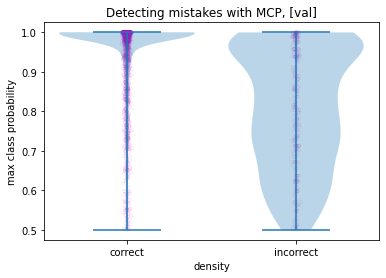

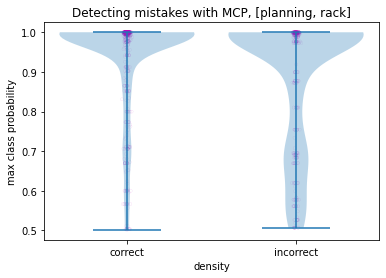

In [5]:
# Can we use the max class probabilities to determine if the classifier is wrong?
for name, datum in data.items():
    probabilities = datum['probabilities']
    is_correct = datum['is_correct']

    is_correct_indices = np.argwhere(is_correct)
    is_incorrect_indices = np.argwhere(np.logical_not(is_correct))

    max_class_probabilities_correct = make_max_class_prob(probabilities[is_correct_indices].squeeze())
    max_class_probabilities_incorrect = make_max_class_prob(probabilities[is_incorrect_indices].squeeze())

    _, ax = plt.subplots()
    ax.set_title(f'Detecting mistakes with MCP, [{name}]')
    myscatter(ax, max_class_probabilities_correct, 1, label='correct', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    myscatter(ax, max_class_probabilities_incorrect, 2, label='incorrect', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    ax.violinplot([max_class_probabilities_correct, max_class_probabilities_incorrect], [1, 2], widths=0.8)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['correct', 'incorrect'])
    ax.set_xlabel("density")
    ax.set_ylabel("max class probability")

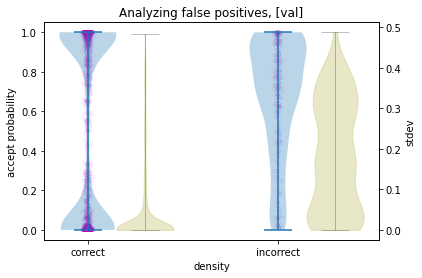

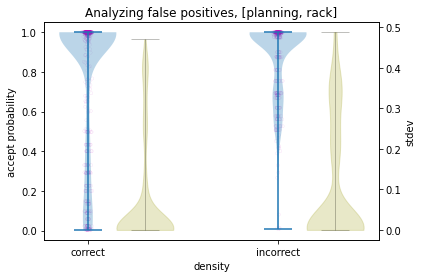

In [17]:
# Analysing false positives
for name, datum in data.items():
    probabilities = datum['probabilities']
    is_correct = datum['is_correct']
    stdevs = datum['stdevs']

    is_correct_indices = np.argwhere(is_correct)
    is_incorrect_indices = np.argwhere(np.logical_not(is_correct))

    probabilities_correct = probabilities[is_correct_indices].squeeze()
    probabilities_incorrect = probabilities[is_incorrect_indices].squeeze()
    stdev_scores_correct = stdevs[is_correct_indices].squeeze()
    stdev_scores_incorrect = stdevs[is_incorrect_indices].squeeze()

    _, ax = plt.subplots()
    ax.set_title(f'Analyzing false positives, [{name}]')
    ax2 = ax.twinx()
    myscatter(ax, probabilities_correct, 1, label='correct', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    myscatter(ax, probabilities_incorrect, 2, label='incorrect', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    ax.violinplot([probabilities_correct, probabilities_incorrect], [1, 2], widths=0.3)
    parts = ax2.violinplot([stdev_scores_correct, stdev_scores_incorrect], [1.3, 2.3], widths=0.3)
    color_violinplot(parts, color='#aaaa3344')
    ax.set_xticks([1,2])
    ax.set_xticklabels(['correct', 'incorrect'])
    ax.set_xlabel("density")
    ax.set_ylabel("accept probability")
    ax2.set_ylabel("stdev")


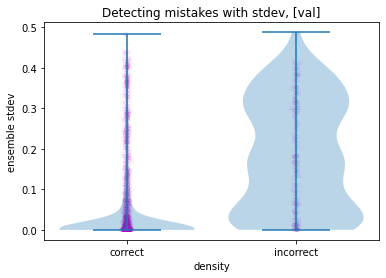

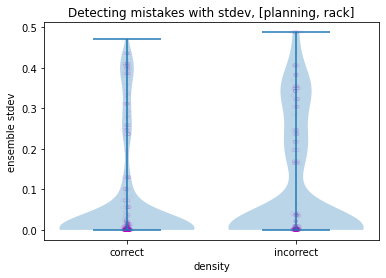

In [7]:
# Can the ensemble stdev tell us whether the classifier is wrong?

for name, datum in data.items():
    stdevs = datum['stdevs']
    is_correct = datum['is_correct']

    is_correct_indices = np.argwhere(is_correct)
    is_incorrect_indices = np.argwhere(np.logical_not(is_correct))

    stdevs_correct = stdevs[is_correct_indices].squeeze()
    stdevs_incorrect = stdevs[is_incorrect_indices].squeeze()

    _, ax = plt.subplots()
    ax.set_title(f'Detecting mistakes with stdev, [{name}]')
    myscatter(ax, stdevs_correct, 1, label='correct', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    myscatter(ax, stdevs_incorrect, 2, label='incorrect', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    ax.violinplot([stdevs_correct, stdevs_incorrect], [1, 2], widths=0.8)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['correct', 'incorrect'])
    ax.set_xlabel("density")
    ax.set_ylabel("ensemble stdev")

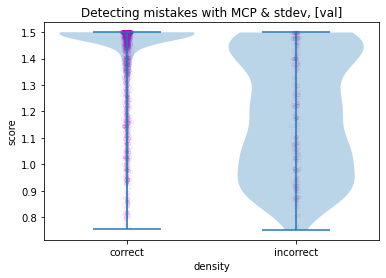

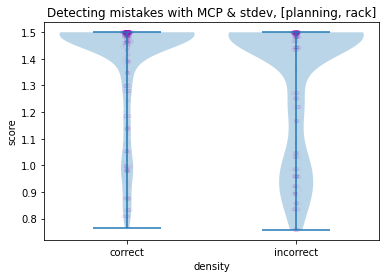

In [8]:
# Can the mean & stdev of ensemble together tell us whether the classifier is wrong?
alpha = 0.5

for name, datum in data.items():
    probabilities = datum['probabilities']
    stdevs = datum['stdevs']
    is_correct = datum['is_correct']

    is_correct_indices = np.argwhere(is_correct)
    is_incorrect_indices = np.argwhere(np.logical_not(is_correct))

    # unbounded
    stdevs_correct = stdevs[is_correct_indices].squeeze()
    stdevs_incorrect = stdevs[is_incorrect_indices].squeeze()

    # ranges from 0 to 1
    max_class_probabilities_correct = make_max_class_prob(probabilities[is_correct_indices].squeeze()) * 2
    max_class_probabilities_incorrect = make_max_class_prob(probabilities[is_incorrect_indices].squeeze()) * 2
    combined_score_correct = alpha * stdev_score(stdevs_correct) + (1 - alpha) * max_class_probabilities_correct
    combined_score_incorrect = alpha * stdev_score(stdevs_incorrect) + (1 - alpha) * max_class_probabilities_incorrect

    _, ax = plt.subplots()
    ax.set_title(f'Detecting mistakes with MCP & stdev, [{name}]')
    myscatter(ax, combined_score_correct, 1, label='correct', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    myscatter(ax, combined_score_incorrect, 2, label='incorrect', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    ax.violinplot([combined_score_correct, combined_score_incorrect], [1, 2], widths=0.8)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['correct', 'incorrect'])
    ax.set_xlabel("density")
    ax.set_ylabel("score")

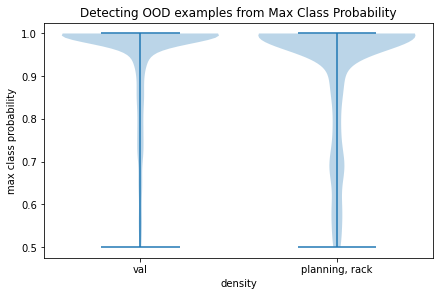

In [9]:
# Can the mean output probability of the ensemble tell us whether the input is OOD?

max_class_probabilities_across_dataset = [make_max_class_prob(v['probabilities']) for v in data.values()]
positions = list(range(len(data)))

_, ax = plt.subplots(constrained_layout=True)
ax.set_title("Detecting OOD examples from Max Class Probability")
ax.violinplot(max_class_probabilities_across_dataset, positions, widths=0.8)
ax.set_xticks(positions)
ax.set_xticklabels(names)
ax.set_xlabel("density")
ax.set_ylabel("max class probability")
plt.savefig("ood_from_mcp.jpeg")

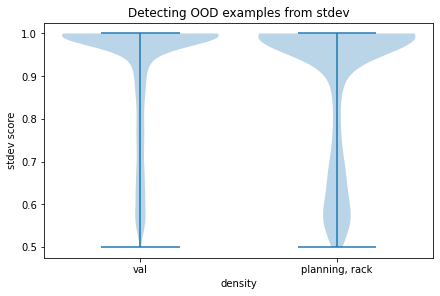

In [10]:
# Can the ensemble stdev tell us whether the input is OOD?

stdevs_across_dataset = [v['stdevs'] for v in data.values()]
positions = list(range(len(data)))

_, ax = plt.subplots(constrained_layout=True)
ax.set_title("Detecting OOD examples from stdev")
ax.violinplot(stdev_score(stdevs_across_dataset), positions, widths=0.8)
ax.set_xticks(positions)
ax.set_xticklabels(names)
ax.set_xlabel("density")
ax.set_ylabel("stdev score")
plt.savefig("ood_from_stdev.jpeg")

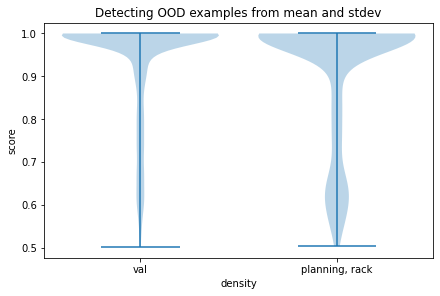

In [11]:
# Can the mean & stdev of ensemble together tell us whether the input is OOD?

probabilities_across_dataset = [v['probabilities'] for v in data.values()]
max_class_probabilities_across_dataset = np.array([make_max_class_prob(v['probabilities']) for v in data.values()])

stdevs_across_dataset = np.array([v['stdevs'] for v in data.values()])
scores_across_dataset = alpha * stdev_score(stdevs_across_dataset) + (1 - alpha) * max_class_probabilities_across_dataset
positions = list(range(len(data)))

_, ax = plt.subplots(constrained_layout=True)
ax.set_title("Detecting OOD examples from mean and stdev")
ax.violinplot(scores_across_dataset, positions, widths=0.8)
ax.set_xticks(positions)
ax.set_xticklabels(names)
ax.set_xlabel("density")
ax.set_ylabel("score")
plt.savefig("ood_from_score.jpeg")


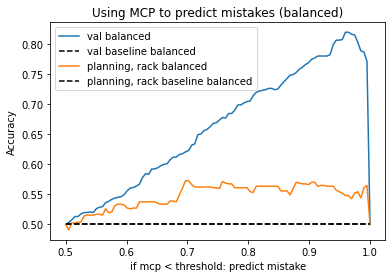

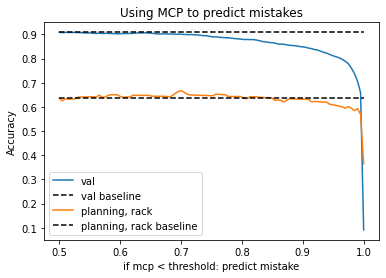

In [12]:
_, ax1 = plt.subplots()
ax1.set_title(f"Using MCP to predict mistakes (balanced)")
ax1.set_xlabel("if mcp < threshold: predict mistake")
ax1.set_ylabel("Accuracy")
_, ax2 = plt.subplots()
ax2.set_title(f"Using MCP to predict mistakes")
ax2.set_xlabel("if mcp < threshold: predict mistake")
ax2.set_ylabel("Accuracy")

def compute_accuracy_at_thresholds(y_pred, y_true):
    n_thresholds = 100
    thresholds = np.linspace(0.5, 1, n_thresholds)
    thresholds_repeated = repeat_tensor(thresholds, repetitions=y_true.shape[0], axis=1, new_axis=True)
    is_correct_repeated = repeat_tensor(y_true, repetitions=n_thresholds, axis=0, new_axis=True)
    y_pred_repeated = repeat_tensor(y_pred, repetitions=n_thresholds, axis=0, new_axis=True)
    predictions_at_threshold = tf.cast(y_pred_repeated > thresholds_repeated, tf.float32)
    predictions_at_threshold = tf.expand_dims(predictions_at_threshold, axis=-1)
    is_correct_repeated = tf.expand_dims(is_correct_repeated, axis=-1)
    accuracy_at_thresholds = tf.reduce_mean(binary_accuracy(is_correct_repeated, predictions_at_threshold), axis=1)
    return accuracy_at_thresholds, thresholds

def balance(y_pred, y_true):
    pos_indices = np.nonzero(y_true)
    neg_indices = np.nonzero(1 - y_true)
    pos = np.ones_like(pos_indices, dtype=np.float32)
    neg = np.zeros_like(neg_indices, dtype=np.float32)
    y_true_balanced = np.array(list(zip(pos.squeeze(), neg.squeeze()))).reshape(-1)
    y_pred_pos = y_pred[pos_indices]
    y_pred_neg = y_pred[neg_indices]
    y_pred_balanced = np.array(list(zip(y_pred_pos.squeeze(), y_pred_neg.squeeze()))).reshape(-1)
    return y_pred_balanced, y_true_balanced

for name, datum in data.items():
    probabilities = datum['probabilities']
    is_correct = datum['is_correct'].astype(np.float32)

    mcp = make_max_class_prob(probabilities)

    mcp_balanced, is_correct_balanced = balance(mcp, is_correct)

    accuracy_at_thresholds, thresholds = compute_accuracy_at_thresholds(mcp, is_correct)
    accuracy_at_thresholds_balanced, _ = compute_accuracy_at_thresholds(mcp_balanced, is_correct_balanced)

    base_accuracy = np.count_nonzero(is_correct) / is_correct.shape[0]
    ax2.plot(thresholds, accuracy_at_thresholds, label=name)
    ax2.plot([0.5, 1.0], [base_accuracy, base_accuracy], c='k', linestyle='--', label=f'{name} baseline')

    ax1.plot(thresholds, accuracy_at_thresholds_balanced, label=f'{name} balanced')
    ax1.plot([0.5, 1.0], [0.5, 0.5], c='k', linestyle='--', label=f'{name} baseline balanced')

ax1.legend()
ax2.legend()

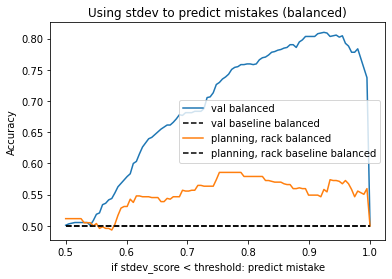

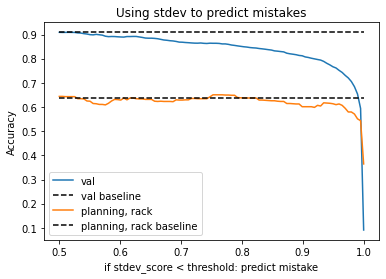

In [13]:
# PR Curve for using MCP to predict whether an example is classifier incorrectly
_, ax1 = plt.subplots()
ax1.set_title(f"Using stdev to predict mistakes (balanced)")
ax1.set_xlabel("if stdev_score < threshold: predict mistake")
ax1.set_ylabel("Accuracy")
_, ax2 = plt.subplots()
ax2.set_title(f"Using stdev to predict mistakes")
ax2.set_xlabel("if stdev_score < threshold: predict mistake")
ax2.set_ylabel("Accuracy")
for name, datum in data.items():
    is_correct = datum['is_correct'].astype(np.float32)
    stdevs = datum['stdevs']

    stdev_scores = stdev_score(stdevs)

    stdev_scores_balanced, is_correct_balanced = balance(stdev_scores, is_correct)

    accuracy_at_thresholds, thresholds = compute_accuracy_at_thresholds(stdev_scores, is_correct)
    accuracy_at_thresholds_balanced, _ = compute_accuracy_at_thresholds(stdev_scores_balanced, is_correct_balanced)

    base_accuracy = np.count_nonzero(is_correct) / is_correct.shape[0]
    ax2.plot(thresholds, accuracy_at_thresholds, label=name)
    ax2.plot([0.5, 1.0], [base_accuracy, base_accuracy], c='k', linestyle='--', label=f'{name} baseline')

    ax1.plot(thresholds, accuracy_at_thresholds_balanced, label=f'{name} balanced')
    ax1.plot([0.5, 1.0], [0.5, 0.5], c='k', linestyle='--', label=f'{name} baseline balanced')

ax1.legend()
ax2.legend()